In [1]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import geometry as Geometry
import environment as Env
import ray as Ray
import simulation as Sim

In [2]:
reload(Geometry)
reload(Env)
reload(Ray)
reload(Sim)

<module 'simulation' from '/Users/anatole/Documents/GitHub/ray-tracer/simulation.py'>

In [3]:
# Source setup
source = Geometry.Point2D(0., 0.)
angle = -0.5

In [29]:
reload(Env)

# floor = lambda x: -550 * np.ones_like(x)
floor = lambda x: -0.27 * x - 500
floor = lambda x: np.maximum(-1 * np.exp(0.0005 * x) - 500, -1500 + 0.02*x)
# floor = lambda x: -500 * np.sin(0.001 * x) - 750
ceiling = lambda x: 0 * np.ones_like(x)

env = Env.Environment2D(
    floor=floor,
    ceiling=ceiling
)

In [31]:
reload(Ray)

ray = Ray.Ray2D(env, source, angle)
ray.propagate()

DEBUG: Ground rebound. New dir: 0.6241047237415912
DEBUG: Surface rebound. New dir: -0.5438119130203224
DEBUG: Ground rebound. New dir: 0.6192134223191437
DEBUG: Surface rebound. New dir: -0.5377617164924502
DEBUG: Ground rebound. New dir: 0.6071462814889
DEBUG: Surface rebound. New dir: -0.5228381019167045
DEBUG: Ground rebound. New dir: 0.5760556502146097
DEBUG: Surface rebound. New dir: -0.48451623205909267
DEBUG: Ground rebound. New dir: 0.484975667398864
DEBUG: Surface rebound. New dir: -0.37362438064663245
DEBUG: Ground rebound. New dir: 0.057961036964568474
DEBUG: Ground rebound. New dir: 0.05503759307031216
DEBUG: Ground rebound. New dir: 0.13389174528083936
DEBUG: Ground rebound. New dir: 0.1866178679055572
DEBUG: Ground rebound. New dir: 0.2255662299536112
MAX ITER


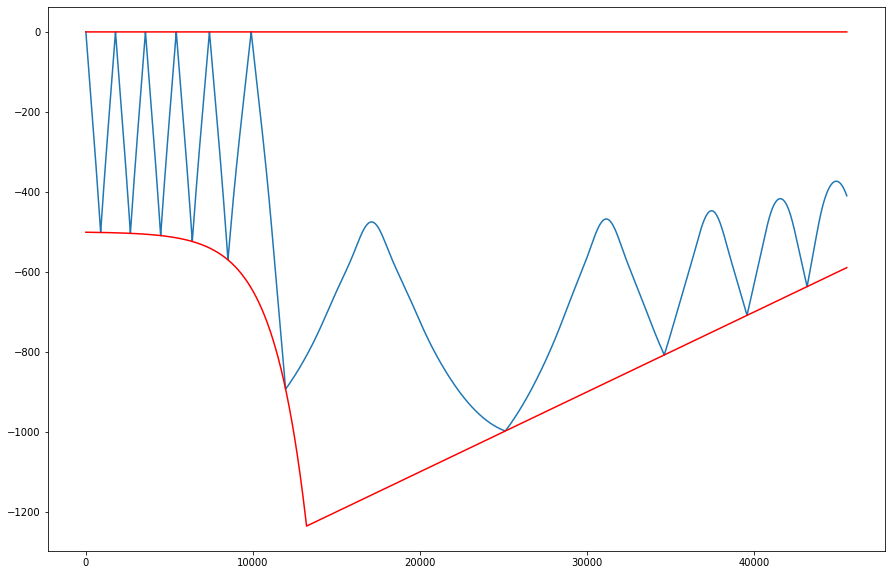

In [36]:
plt.figure(figsize=(15, 10))
plt.plot(ray.X, ray.Z)
plt.plot(ray.X, ceiling(ray.X), c='red')
plt.plot(ray.X, floor(ray.X), c='red')
# plt.xlim((env.range_min.x, env.range_max.x))
# plt.ylim((env.range_min.z, env.range_max.z))
# plt.xlim((0, 45000))
# plt.ylim((-45000, 0))
plt.show()